In [1]:
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import cv2
import matplotlib as mlt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import metrics

Matplotlib created a temporary config/cache directory at C:\Users\MICHAE~2.HOD\AppData\Local\Temp\1\matplotlib-q0twdy7c because the default path (M:\.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
#Notebook config
skip_image_downsize = True
skip_randomized_search = True
csv_or_image = 'csv'
image_path = 'resized'
image_width = 48
image_height = 36
skincancer_subfolder = 'skincancer'
data_path_bw = 'skincancer/hmnist_28_28_L.csv' #'C:\\Users\\Maria\\Desktop\\DS\\4\\Assignments\\Group\\archive\\hmnist_28_28_L.csv'
metadata_path = 'skincancer/HAM10000_metadata.csv' #'C:\\Users\\Maria\\Desktop\\DS\\4\\Assignments\\Group\\archive\\HAM10000_metadata.csv'

### Function Definitions

In [3]:
# iterates through subfolder at same level as notebook
# converts all .jpg files to default size 48x36
# a folder named "resized" must exist at same level as notebook
def image_size_reduction(skincancer_subfolder, width=image_width, height=image_height):
    for root, dirs, files in os.walk(skincancer_subfolder):
        for file in files:
            if file.endswith('.jpg'):
                img = Image.open(os.path.join(root, file))
                img_resized = img.resize((width, height),Image.ANTIALIAS)
                img_resized.save('resized/'+file,optimize=True,quality=95)

In [4]:
# returns an array of images found in given folder
def load_images(image_path=image_path):
    lesions = []
    for root, dirs, files in os.walk(image_path):
        for file in files:
            if file.endswith(".jpg"):
                lesions.append(cv2.imread(os.path.join(root, file)))
            
    lesions = np.array(lesions)
    return lesions

In [5]:
# flattens an array of images
def convert_images_to_array(lesions):
    image = []

    for i in range (0, lesions.shape[0]):
        img = lesions[i].flatten()
        image.append(img)

    image = np.array(image, dtype=np.uint8)
    return image

In [6]:
# Displays confusion matrix
def display_confusion_matrix(y_actual, y_predicted, classes=7):
   
    label_mapping = { 
        0: 'akiec',
        1: 'bcc',
        2: 'bkl',
        3: 'df',
        4: 'nv',
        5: 'vasc',
        6: 'mel'
    }
   
    cm=confusion_matrix(y_actual, y_predicted)

    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')

    plt.xticks(np.arange(classes) + 0.5, label_mapping.values())
    plt.xlabel("Predicted")

    plt.yticks(np.arange(classes) + 0.5, label_mapping.values())
    plt.ylabel("Actual")

    plt.title("Confusion Matrix")

    plt.show()

### Part 1: Data Discovery

In [7]:
# load dataframe from 28x28 pixel images saved to csv or from collection of images
if csv_or_image == 'csv':
    lesion_df = pd.read_csv(data_path_bw)
    lesion_df = lesion_df.drop('label', axis=1)
else:  
    if not skip_image_downsize:
        image_size_reduction()
        
    lesions = load_images()
    image_array = convert_images_to_array(lesions)
    feat_cols = ['pixel' + str(i) for i in range(image_array.shape[1])]
    lesion_df = pd.DataFrame(image_array, columns=feat_cols)

data = lesion_df.copy()

In [8]:
#load metadata
lesion_metadata = pd.read_csv(metadata_path)

mdata = lesion_metadata.copy()
mdata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [9]:
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel5174,pixel5175,pixel5176,pixel5177,pixel5178,pixel5179,pixel5180,pixel5181,pixel5182,pixel5183
0,133,129,234,129,125,230,129,125,230,132,...,224,138,149,223,136,147,221,131,142,216
1,131,121,214,132,122,215,129,120,217,128,...,215,145,140,215,143,139,211,137,133,205
2,179,171,242,178,171,244,181,174,249,179,...,213,156,146,216,159,146,214,157,144,212
3,136,121,212,134,119,210,137,121,209,137,...,189,118,118,188,123,121,191,124,122,192
4,43,33,75,29,21,68,51,49,108,123,...,196,99,100,161,43,41,93,33,30,79


In [10]:
# check for nulls
data.isna().sum().sum()

0

In [11]:
y = mdata['dx']
X = data

In [12]:
y.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [13]:
#normalize
X = X / 255

X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel5174,pixel5175,pixel5176,pixel5177,pixel5178,pixel5179,pixel5180,pixel5181,pixel5182,pixel5183
0,0.521569,0.505882,0.917647,0.505882,0.490196,0.901961,0.505882,0.490196,0.901961,0.517647,...,0.878431,0.541176,0.584314,0.874510,0.533333,0.576471,0.866667,0.513725,0.556863,0.847059
1,0.513725,0.474510,0.839216,0.517647,0.478431,0.843137,0.505882,0.470588,0.850980,0.501961,...,0.843137,0.568627,0.549020,0.843137,0.560784,0.545098,0.827451,0.537255,0.521569,0.803922
2,0.701961,0.670588,0.949020,0.698039,0.670588,0.956863,0.709804,0.682353,0.976471,0.701961,...,0.835294,0.611765,0.572549,0.847059,0.623529,0.572549,0.839216,0.615686,0.564706,0.831373
3,0.533333,0.474510,0.831373,0.525490,0.466667,0.823529,0.537255,0.474510,0.819608,0.537255,...,0.741176,0.462745,0.462745,0.737255,0.482353,0.474510,0.749020,0.486275,0.478431,0.752941
4,0.168627,0.129412,0.294118,0.113725,0.082353,0.266667,0.200000,0.192157,0.423529,0.482353,...,0.768627,0.388235,0.392157,0.631373,0.168627,0.160784,0.364706,0.129412,0.117647,0.309804


In [14]:
num_rows = mdata.shape[0]
num_cols = mdata.shape[1]
input_cols = mdata.columns[:5].tolist()

print(f"No. Rows: {num_rows}")
print(f"No. Columns: {num_cols}")
print(f"Columns: {input_cols}")

No. Rows: 10015
No. Columns: 7
Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age']


In [15]:
categorical_cols = mdata.select_dtypes(exclude=["number"])
categorical_cols = categorical_cols.columns.tolist()

categorical_cols

['lesion_id', 'image_id', 'dx', 'dx_type', 'sex', 'localization']

In [16]:
numerical_cols = mdata.select_dtypes(include=["number"])
numerical_cols = numerical_cols.columns.tolist()

numerical_cols

['age']

In [17]:
output_cols = mdata.columns[2:3].tolist()

c:\miniconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Detections by age'}, xlabel='age', ylabel='Density'>

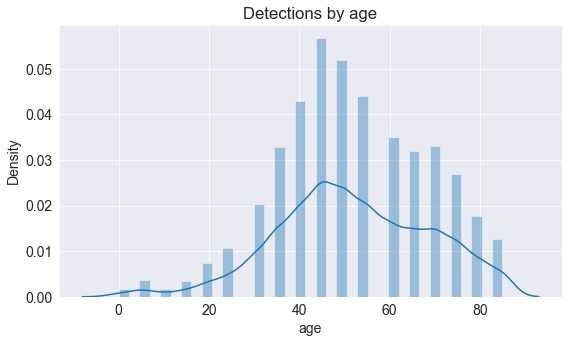

In [18]:
sns.set_style("darkgrid")
mlt.rcParams['font.size'] = 14
mlt.rcParams['figure.figsize'] = (9, 5)

plt.title("Detections by age")
age = mdata.loc[: , "age"]
sns.distplot(age)

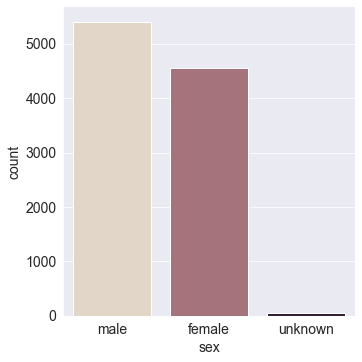

In [19]:
sns.catplot(x="sex", kind="count", palette="ch:.25", data=mdata);

In [20]:
mdata.dx.unique() # to get distinct diagnoses

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [21]:
mdata.dx_type.unique()

array(['histo', 'consensus', 'confocal', 'follow_up'], dtype=object)

In [22]:
#create 7 subsets for each dx
bk1_df = mdata[(mdata['dx'] == 'bkl')]
nv_df = mdata[(mdata['dx'] == 'nv')]
mel_df = mdata[(mdata['dx'] == 'mel')]
vasc_df = mdata[(mdata['dx'] == 'vasc')]
bcc_df = mdata[(mdata['dx'] == 'bcc')]
akiec_df = mdata[(mdata['dx'] == 'akiec')]
df_df = mdata[(mdata['dx'] == 'df')]

In [23]:
# this will tell us how many images are associated with each lesion_id
df = mdata.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [24]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
mdata['duplicates'] = mdata['lesion_id']
# apply the function to this new column
mdata['duplicates'] = mdata['duplicates'].apply(identify_duplicates)

mdata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [25]:
mdata['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [26]:
# now we filter out images that don't have duplicates
df = mdata[mdata['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [27]:
#exclude nulls
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             47
sex              0
localization     0
duplicates       0
dtype: int64

In [28]:
df['age'].fillna((df['age'].mean()), inplace=True)

c:\miniconda3\envs\py37\lib\site-packages\pandas\core\series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [29]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
duplicates      0
dtype: int64

<AxesSubplot:>

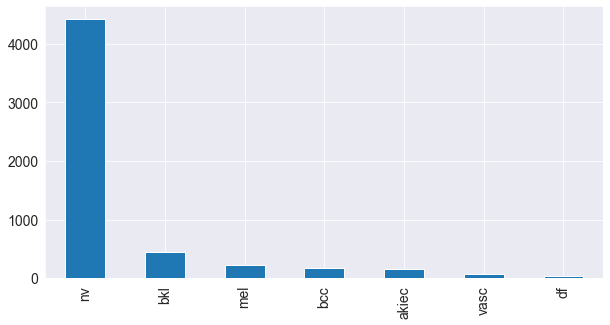

In [30]:
#excluded
#distribution of types:
# Distribution of 7 classes
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['dx'].value_counts().plot(kind='bar', ax=ax1)

<AxesSubplot:>

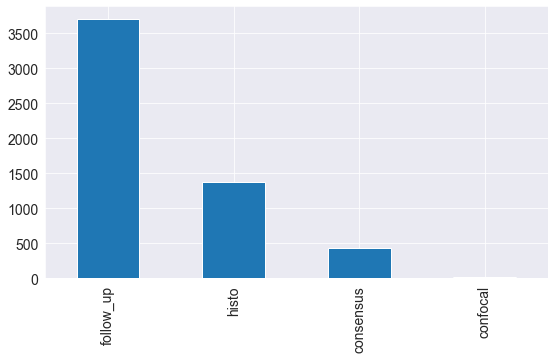

In [31]:
# distribution of investigation type -  dx_type

df['dx_type'].value_counts().plot(kind='bar')

<AxesSubplot:>

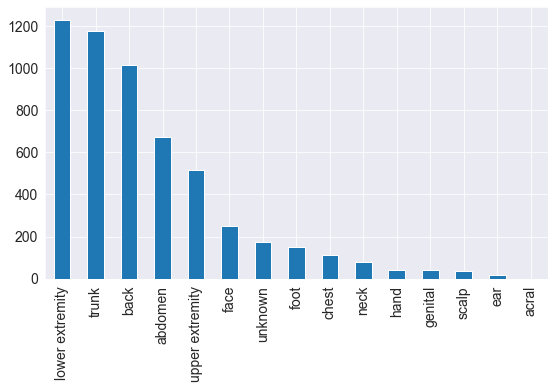

In [32]:
#localization
df['localization'].value_counts().plot(kind='bar')

c:\miniconda3\envs\py37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='age', ylabel='dx'>

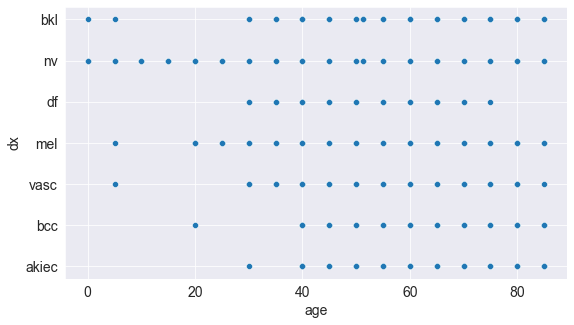

In [33]:
#age by cancer type
sns.scatterplot('age','dx',data=df)

In [34]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_test = train_test_split(df, test_size=0.2, random_state=101, stratify=y)

df_test.shape

(1103, 8)

In [35]:
df_test['dx'].value_counts()

nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

In [36]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_test['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
mdata['train_or_val'] = mdata['image_id']
# apply the function to this new column
mdata['train_or_val'] = mdata['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = mdata[mdata['train_or_val'] == 'train']


print(len(df_train))
print(len(df_test))

8912
1103


In [37]:
df_train['dx'].value_counts()

nv       5822
mel      1067
bkl      1011
bcc       479
akiec     297
vasc      129
df        107
Name: dx, dtype: int64

In [38]:
df_test['dx'].value_counts()

nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

In [39]:
# Set the image_id as the index in metadata
mdata.set_index('image_id', inplace=True)

In [40]:
X = np.array(X)
print(X.shape)

(10015, 5184)


In [41]:
if csv_or_image == 'csv':
    X = X.reshape(-1, 28, 28, 1)
    
print(X.shape)

(10015, 5184)


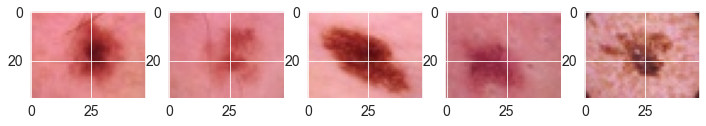

In [42]:
#as in 6
lesion_plot = plt.figure(figsize=(12, 12))

if csv_or_image == 'csv':
    ax = lesion_plot.add_subplot(1,5,1)
    ax.imshow(X[0], cmap='gray')
    ax = lesion_plot.add_subplot(1,5,2)
    ax.imshow(X[1], cmap='gray')
    ax = lesion_plot.add_subplot(1,5,3)
    ax.imshow(X[2], cmap='gray')
    ax = lesion_plot.add_subplot(1,5,4)
    ax.imshow(X[3], cmap='gray')
    ax = lesion_plot.add_subplot(1,5,5)
    ax.imshow(X[4], cmap='gray')
else:
    ax = lesion_plot.add_subplot(1,5,1)
    ax.imshow(cv2.cvtColor(lesions[0], cv2.COLOR_BGR2RGB))
    ax = lesion_plot.add_subplot(1,5,2)
    ax.imshow(cv2.cvtColor(lesions[1], cv2.COLOR_BGR2RGB))
    ax = lesion_plot.add_subplot(1,5,3)
    ax.imshow(cv2.cvtColor(lesions[2], cv2.COLOR_BGR2RGB))
    ax = lesion_plot.add_subplot(1,5,4)
    ax.imshow(cv2.cvtColor(lesions[3], cv2.COLOR_BGR2RGB))
    ax = lesion_plot.add_subplot(1,5,5)
    ax.imshow(cv2.cvtColor(lesions[4], cv2.COLOR_BGR2RGB))   

### Part 2. Dimensionality Reduction

In [43]:
#normalize
image_df = lesion_df / 255

In [44]:
image_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel5174,pixel5175,pixel5176,pixel5177,pixel5178,pixel5179,pixel5180,pixel5181,pixel5182,pixel5183
0,0.521569,0.505882,0.917647,0.505882,0.490196,0.901961,0.505882,0.490196,0.901961,0.517647,...,0.878431,0.541176,0.584314,0.874510,0.533333,0.576471,0.866667,0.513725,0.556863,0.847059
1,0.513725,0.474510,0.839216,0.517647,0.478431,0.843137,0.505882,0.470588,0.850980,0.501961,...,0.843137,0.568627,0.549020,0.843137,0.560784,0.545098,0.827451,0.537255,0.521569,0.803922
2,0.701961,0.670588,0.949020,0.698039,0.670588,0.956863,0.709804,0.682353,0.976471,0.701961,...,0.835294,0.611765,0.572549,0.847059,0.623529,0.572549,0.839216,0.615686,0.564706,0.831373
3,0.533333,0.474510,0.831373,0.525490,0.466667,0.823529,0.537255,0.474510,0.819608,0.537255,...,0.741176,0.462745,0.462745,0.737255,0.482353,0.474510,0.749020,0.486275,0.478431,0.752941
4,0.168627,0.129412,0.294118,0.113725,0.082353,0.266667,0.200000,0.192157,0.423529,0.482353,...,0.768627,0.388235,0.392157,0.631373,0.168627,0.160784,0.364706,0.129412,0.117647,0.309804


In [45]:
#TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
tsne_result = tsne.fit_transform(image_df)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10015 samples in 0.063s...
[t-SNE] Computed neighbors for 10015 samples in 6.824s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10015
[t-SNE] Computed conditional probabilities for sample 2000 / 10015
[t-SNE] Computed conditional probabilities for sample 3000 / 10015
[t-SNE] Computed conditional probabilities for sample 4000 / 10015
[t-SNE] Computed conditional probabilities for sample 5000 / 10015
[t-SNE] Computed conditional probabilities for sample 6000 / 10015
[t-SNE] Computed conditional probabilities for sample 7000 / 10015
[t-SNE] Computed conditional probabilities for sample 8000 / 10015
[t-SNE] Computed conditional probabilities for sample 9000 / 10015
[t-SNE] Computed conditional probabilities for sample 10000 / 10015
[t-SNE] Computed conditional probabilities for sample 10015 / 10015
[t-SNE] Mean sigma: 2.033252
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.918579
[t-SNE] KL

<AxesSubplot:xlabel='x', ylabel='y'>

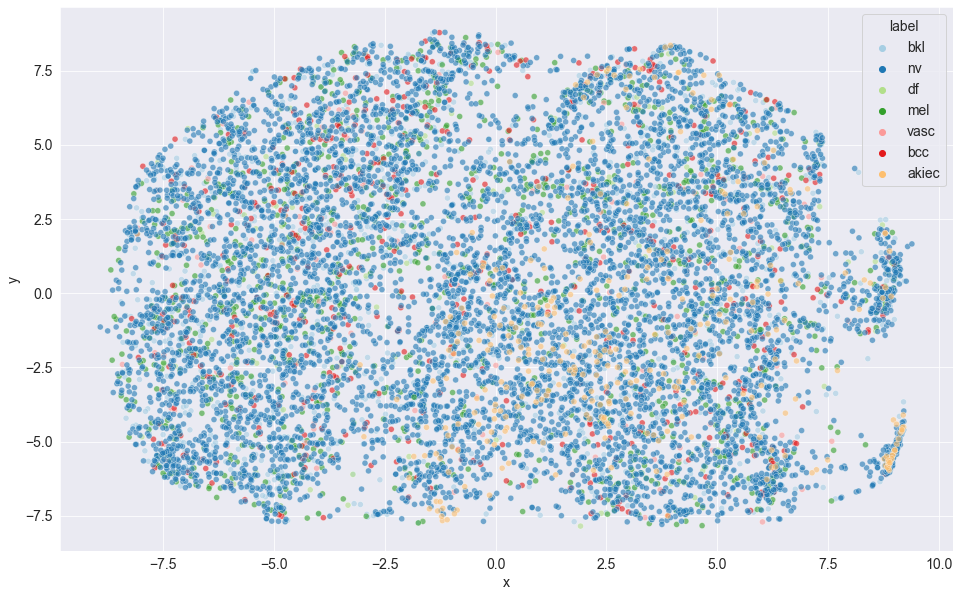

In [46]:
#tsne_result
tsne_df = pd.DataFrame({'x': tsne_result[:, 0], 'y': tsne_result[:, 1], 'label': mdata['dx']})

plt.figure(figsize=(16,10)) 
sns.scatterplot(x='x', y='y', hue='label', palette=sns.color_palette('Paired', 7), 
                data=tsne_df, alpha=0.6)

In [47]:
pca_img = PCA(n_components=50)
pca_result = pca_img.fit_transform(image_df)

In [48]:
print('Explained variation per principal component: {}'.format(pca_img.explained_variance_ratio_))

Explained variation per principal component: [0.29984051 0.22075934 0.12017854 0.04083595 0.03668517 0.03528315
 0.0212799  0.01840789 0.01593226 0.01508641 0.01305498 0.01066135
 0.0079396  0.00647435 0.0064385  0.00539673 0.00527958 0.00506932
 0.0046007  0.00429512 0.00327821 0.00296829 0.00280772 0.00274675
 0.00261798 0.00251754 0.00239915 0.00213762 0.00210522 0.00199877
 0.00157664 0.00146363 0.00139266 0.00137507 0.0013362  0.00131408
 0.00126471 0.0012182  0.00115658 0.00112775 0.00105212 0.00102787
 0.0010071  0.00092685 0.00092063 0.00088013 0.0008418  0.00083081
 0.00079925 0.00079499]


In [49]:
pca = PCA()
pca.fit(image_df)

cumsum_ = np.cumsum(pca.explained_variance_ratio_)

d = np.argmax(cumsum_ >=0.95) + 1

print('The number of dimensions required to preserve 95% of HAM data set variance is {}.'.format(d))

The number of dimensions required to preserve 95% of HAM data set variance is 64.


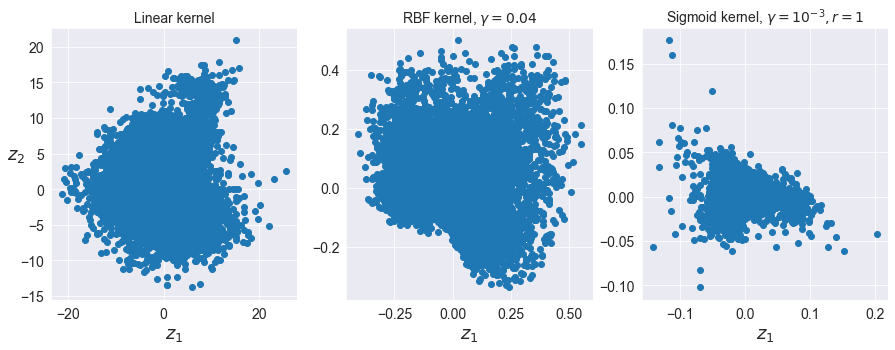

In [50]:
#KernelPCA
lin_pca = KernelPCA(n_components=2, kernel='linear', fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel='sigmoid', gamma=0.001, coef0=1, fit_inverse_transform=True)

plt.figure(figsize=(15, 5))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(image_df)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

### Part 3. Preparing Data for Classification

In [51]:
image_df = lesion_df
image_df['age'] = lesion_metadata['age']
image_df['sex'] = lesion_metadata['sex']
image_df['localization'] = lesion_metadata['localization']
image_df['label'] = lesion_metadata['dx']

In [52]:
image_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel5178,pixel5179,pixel5180,pixel5181,pixel5182,pixel5183,age,sex,localization,label
0,133,129,234,129,125,230,129,125,230,132,...,136,147,221,131,142,216,80.0,male,scalp,bkl
1,131,121,214,132,122,215,129,120,217,128,...,143,139,211,137,133,205,80.0,male,scalp,bkl
2,179,171,242,178,171,244,181,174,249,179,...,159,146,214,157,144,212,80.0,male,scalp,bkl
3,136,121,212,134,119,210,137,121,209,137,...,123,121,191,124,122,192,80.0,male,scalp,bkl
4,43,33,75,29,21,68,51,49,108,123,...,43,41,93,33,30,79,75.0,male,ear,bkl


In [ ]:
#Replace missing age with mean
image_df['age'].fillna((image_df['age'].mean()), inplace=True)

In [53]:
#Drop any remaining null values
image_df = image_df.dropna()

In [54]:
# setting aside the test set
X_train, X_test, y_train, y_test = train_test_split(image_df.drop('label', axis=1), image_df['label'], stratify=image_df['label'], test_size=0.2, random_state=42)

In [55]:
#one hot encoding on sex and localization
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
cat_steps = [cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, ['sex', 'localization'])]

In [56]:
numericalVars = X_train.columns.tolist()
numericalVars.remove('sex')
numericalVars.remove('localization')

In [57]:
#scaling on all numerical columns
num_scl_step = ('scl', MinMaxScaler())
num_steps = [num_scl_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, numericalVars)]

In [58]:
#fit
ct = ColumnTransformer(transformers=cat_transformers + num_transformers)
ct.fit(X_train)
X_train = ct.transform(X_train)

In [59]:
#transform test set
X_test = ct.transform(X_test)

In [60]:
#reduce nv class by 10%
undersample = RandomUnderSampler(sampling_strategy={'nv':4795}, random_state=42)
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [61]:
#verify reduction
y_train.groupby(y_train).count()

label
akiec     261
bcc       411
bkl       871
df         92
mel       889
nv       4795
vasc      114
Name: label, dtype: int64

In [62]:
#use smote to oversample under-represented classes
oversample = SMOTE(sampling_strategy='not majority', random_state=42, n_jobs=-1)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [63]:
#verify oversampling
y_train.groupby(y_train).count()

label
akiec    4795
bcc      4795
bkl      4795
df       4795
mel      4795
nv       4795
vasc     4795
Name: label, dtype: int64

In [64]:
#Running TSNE again, this time with 3 dimensions, to visualize the training set after under/over sampling
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, random_state=42)
tsne_result = tsne.fit_transform(X_train)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 33565 samples in 0.223s...
[t-SNE] Computed neighbors for 33565 samples in 112.920s...
[t-SNE] Computed conditional probabilities for sample 1000 / 33565
[t-SNE] Computed conditional probabilities for sample 2000 / 33565
[t-SNE] Computed conditional probabilities for sample 3000 / 33565
[t-SNE] Computed conditional probabilities for sample 4000 / 33565
[t-SNE] Computed conditional probabilities for sample 5000 / 33565
[t-SNE] Computed conditional probabilities for sample 6000 / 33565
[t-SNE] Computed conditional probabilities for sample 7000 / 33565
[t-SNE] Computed conditional probabilities for sample 8000 / 33565
[t-SNE] Computed conditional probabilities for sample 9000 / 33565
[t-SNE] Computed conditional probabilities for sample 10000 / 33565
[t-SNE] Computed conditional probabilities for sample 11000 / 33565
[t-SNE] Computed conditional probabilities for sample 12000 / 33565
[t-SNE] Computed conditional probabilities for 

In [65]:
#tsne_result
tsne_df = pd.DataFrame({'x': tsne_result[:, 0], 'y': tsne_result[:, 1], 'z': tsne_result[:, 2], 'label': y_train})

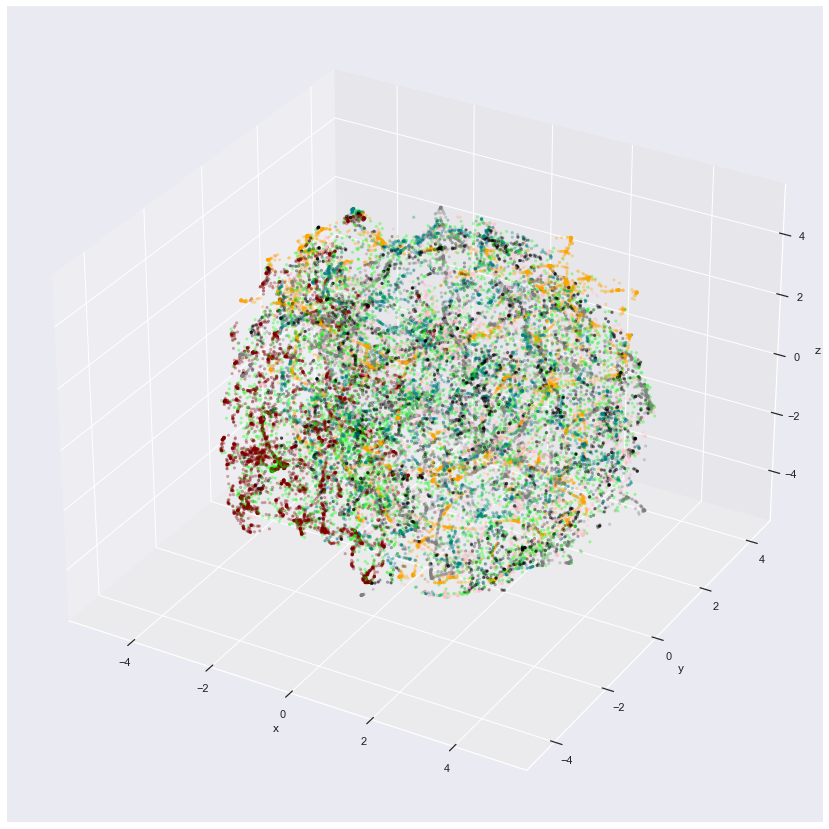

In [66]:
#plot
sns.set(style = "darkgrid")

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection = '3d')

x = tsne_df['x']
y = tsne_df['y']
z = tsne_df['z']
colors = {'akiec':'maroon', 'bcc':'teal', 'bkl':'black', 'df':'orange', 'nv':'lime', 'vasc':'grey', 'mel':'pink'}

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.scatter(x, y, z, alpha=0.25, marker='.', c=tsne_df['label'].apply(lambda x: colors[x]))

plt.show()

##### Due to the small size, we don't need to perform classification on a reduced dataset; however, the image provides some insight as to how classification might perform.

### Part 4. Classification

In [67]:
#DecisionTreeClassifier with entropy
tree_clf = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

In [68]:
# Examine feature importance 
zip(X_train, tree_clf.feature_importances_)
zipped = zip(X_train, tree_clf.feature_importances_)
list(zipped)

[(array([0.        , 1.        , 0.        , ..., 0.28225806, 0.38431373,
         0.82352941]),
  0.0),
 (array([1.        , 0.        , 0.        , ..., 0.        , 0.00392157,
         0.70588235]),
  0.00760211249700825),
 (array([0.        , 1.        , 0.        , ..., 0.44758065, 0.54901961,
         0.64705882]),
  0.0),
 (array([1.        , 0.        , 0.        , ..., 0.72177419, 0.72941176,
         0.47058824]),
  0.0),
 (array([0.        , 1.        , 0.        , ..., 0.61693548, 0.65098039,
         0.82352941]),
  0.0),
 (array([0.        , 1.        , 0.        , ..., 0.00403226, 0.00392157,
         0.82352941]),
  0.008416356837594167),
 (array([0.        , 1.        , 0.        , ..., 0.56854839, 0.67843137,
         0.76470588]),
  0.0),
 (array([0.        , 1.        , 0.        , ..., 0.4516129 , 0.54509804,
         0.94117647]),
  0.0),
 (array([0.        , 1.        , 0.        , ..., 0.51209677, 0.61176471,
         0.64705882]),
  0.21488679606166217),
 (arra

In [ ]:
# Compare performance of 8 classifiers using default hyperparameters
# Using f1 weighted scoring for multiclass classification

classifiers = [
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    SVC(),
    SVC(kernel='linear'),
    GaussianNB(), 
    GradientBoostingClassifier(), 
    AdaBoostClassifier(),
    ExtraTreesClassifier()
]

classifier_names = [
    'Random Forest Classifier',   
    'Decision Tree Classifier',
    'SVM classifier with RBF kernel',
    'SVM classifier with linear kernel',
    'Gaussian Naive Bayes',
    'Gradient Boosting', 
    'Ada Boosting',
    'Extra Tree'
]

for clf, clf_name in zip(classifiers, classifier_names):
    time_start = time.time()
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_weighted')    
    print(clf_name, ' mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(cv_scores.var()*100, 3),'%')
    print('Execution time: {} seconds'.format(time.time()-time_start))

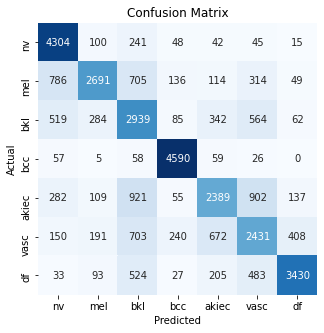

In [33]:
#SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)
display_confusion_matrix(y_train, y_train_pred)

f1:	 0.6336997100384457


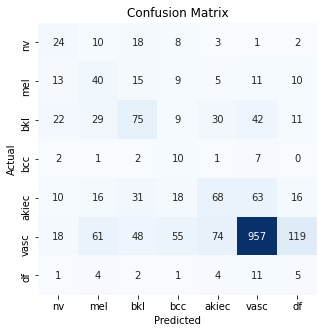

In [57]:
#test
y_predicted_sgd = sgd_clf.predict(X_test)
print('f1:\t', metrics.f1_score(y_true=y_test, y_pred=y_predicted_sgd, average='weighted'))
display_confusion_matrix(y_test, y_predicted_sgd)

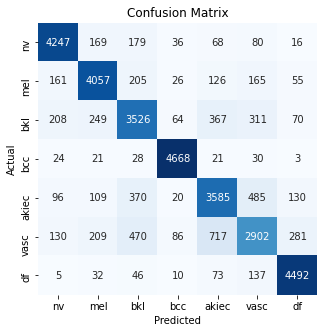

In [58]:
#DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_train_pred = cross_val_predict(dt_clf, X_train, y_train, cv=3, n_jobs=-1)
display_confusion_matrix(y_train, y_train_pred)

f1:	 0.5633005378813037


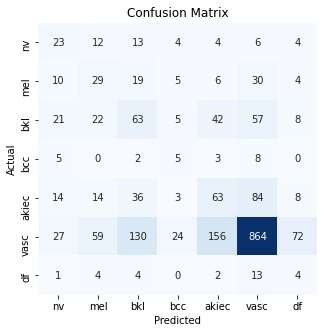

In [59]:
#test
y_predicted_dt = dt_clf.predict(X_test)
print('f1:\t', metrics.f1_score(y_true=y_test, y_pred=y_predicted_dt, average='weighted'))
display_confusion_matrix(y_test, y_predicted_dt)

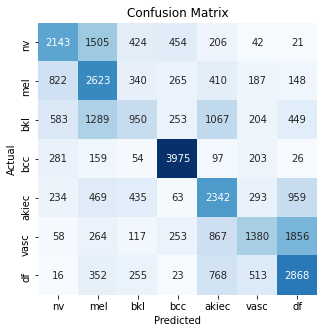

In [60]:
#AdaBoostClassifier
ada_clf = AdaBoostClassifier(random_state=42)
ada_clf.fit(X_train, y_train)
y_train_pred = cross_val_predict(ada_clf, X_train, y_train, cv=3, n_jobs=-1)
display_confusion_matrix(y_train, y_train_pred)

f1:	 0.34567824430438826


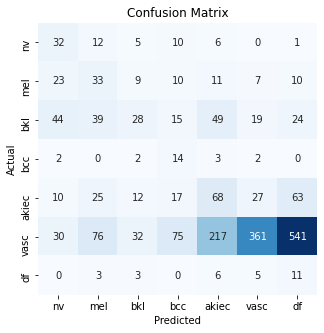

In [62]:
#test
y_predicted_ada = ada_clf.predict(X_test)
print('f1:\t', metrics.f1_score(y_true=y_test, y_pred=y_predicted_ada, average='weighted'))
display_confusion_matrix(y_test, y_predicted_ada)

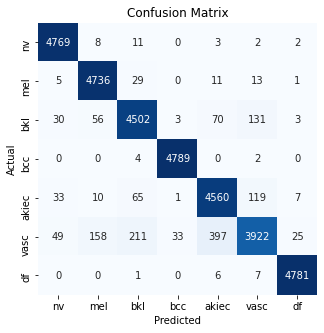

In [63]:
#RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_train_pred = cross_val_predict(rf_clf, X_train, y_train, cv=3, n_jobs=-1)
display_confusion_matrix(y_train, y_train_pred)

f1:	 0.683069513632669


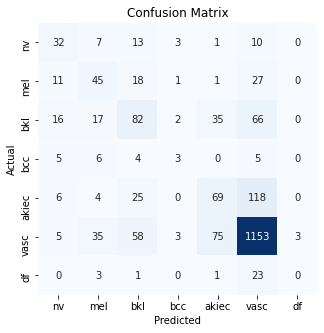

In [64]:
#test
y_predicted_rf = rf_clf.predict(X_test)
print('f1:\t', metrics.f1_score(y_true=y_test, y_pred=y_predicted_rf, average='weighted'))
display_confusion_matrix(y_test, y_predicted_rf)

In [ ]:
#Hyperparameter tuning on RandomForestClassifier
#Will skip if skip_randomized_search feature flag is disabled
#12+ hours using 3 cores on Intel i7 with 16GB RAM against 48x36 colour images
if not skip_randomized_search:
    n_estimators = np.arange(100, 1000, 200)
    max_features = ['auto', 'sqrt']
    max_depth = np.arange(10, 100, 25)
    min_samples_split = np.arange(1, 100, 10)
    min_samples_leaf = [1, 2, 4, 8]
    bootstrap = [True, False]

    param_distributions = {'n_estimators': n_estimators,
                           'max_features': max_features,
                           'max_depth': max_depth,
                           'min_samples_split': min_samples_split,
                           'min_samples_leaf': min_samples_leaf,
                           'bootstrap': bootstrap}

    rf_clf2 = RandomForestClassifier()

    startTime = datetime.datetime.now()
    random_search = RandomizedSearchCV(estimator=rf_clf2, param_distributions=param_distributions, scoring='f1_weighted',
                                       n_jobs=3, cv=3, n_iter=50, random_state=42)
    random_search.fit(X=X_train, y=y_train)

    random_search.best_params_

#### Best estimator for 48x36 colour images:

n_estimators: 100 <br>
min_samples_split: 11 <br>
min_samples_leaf: 1 <br>
max_features: auto <br>
max_depth: 35 <br>
bootstrap: False

f1:	 0.6904385694666083


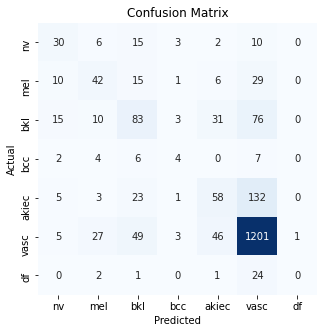

In [66]:
#Retraining and testing against RandomForestClassifier with best optimal hyperparameters
rf_best = RandomForestClassifier(n_estimators=100, min_samples_split=11, min_samples_leaf=1, max_features='auto', max_depth=35, bootstrap=False, n_jobs=-1, random_state=42)
rf_best.fit(X_train, y_train)
y_predicted_rf_best = rf_best.predict(X_test)
print('f1:\t', metrics.f1_score(y_true=y_test, y_pred=y_predicted_rf_best, average='weighted'))
display_confusion_matrix(y_test, y_predicted_rf_best)